In [1]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # conv 3x3, batch normalization, relu

        def CBR2d(in_channels, out_channels, kernel_size =3, stride =1, padding = 1, bias = True):
            layers =[]
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                        kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            conv_block = nn.Sequential(*layers)
            return conv_block

        # Unet Encoder

        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        self.pool1=nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        #Unet Decoder

        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        self.unpool4 = nn.ConvTranspose2d(in_channels=512,out_channels=512,kernel_size=2,stride=2,padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=512*2, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CBR2d(in_channels=256*2, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CBR2d(in_channels=128*2, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CBR2d(in_channels=64*2, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)


    def forward(self, x):
        #encoder
        enc1_1 =self.enc1_1(x)
        enc1_2 =self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        #Decoder

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)

        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2,enc2_2),dim =1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

/home/choi/anaconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [3]:
# 데이터 저장경로
data_dir = './datasets'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(data_dir,name_label))
img_input = Image.open(os.path.join(data_dir,name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

print('nx:', nx)
print('ny:', ny)
print('frame:', nframe)

nx: 512
ny: 512
frame: 30


512 * 512 이고 30프레임이 담겨있음, train: val : test = 24: 3: 3

In [4]:
nframe_train = 24
nframe_val = 3
nframe_test = 3

assert nframe_train + nframe_val + nframe_test ==30, "총 프레임 갯수가 30이어야합니다." # != 이게 아니면

# 데이터 나누어서 저장할 경로 설정

dirs = {}

for folder in ['train', 'val', 'test']:
    dirs[folder] = os.path.join(data_dir,folder)
    if not os.path.exists(dirs[folder]):
        os.makedirs(dirs[folder])

# train_dir = os.path.join(data_dir, 'train')
# val_dir = os.path.join(data_dir,'val')
# test_dir = os.path.join(data_dir, 'test')

# if not os.path.exists(train_dir):
#     os.makedirs(train_dir)


# if not os.path.exists(val_dir):
#     os.makedirs(val_dir)

# if not os.path.exists(test_dir):
#     os.makedirs(test_dir)

# 데이터 랜덤 설정 
id_frame = np.arange(nframe) #0부터 nframe -1 까지의 정수들이 순차적으로 담긴 배열을 생성 numpy 배열로
np.random.shuffle(id_frame)
print(id_frame)



[21 24  7 27 20  9 10  2 15 23 11  5 16 13 12 22  6  3 17  8 25 29 14  4
  1 26  0 18 28 19]


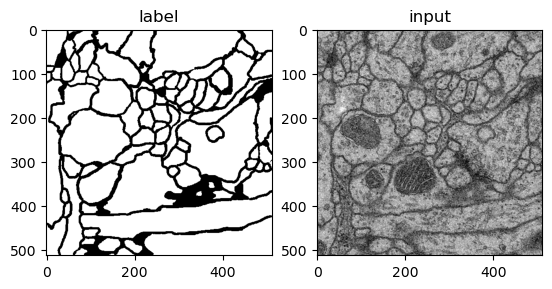

In [5]:
# 데이터 섞어서 train 저장
offset_nframe = 0
for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dirs['train'],f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(dirs['train'],f'input_{i:03d}.npy'), input_)

# 데이터 섞어서 val 저장
offset_nframe += nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dirs['val'], f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(dirs['val'], f'input_{i:03d}.npy'), input_)

# 데이터 섞어서 test 저장 
offset_nframe += nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dirs['test'], f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(dirs['test'], f'input_{i:03d}.npy'), input_)


plt.subplot(121)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_,cmap='gray')
plt.title('input')

plt.show()

In [6]:
#dataset

import torch.utils
import torch.utils.data


class MyDataset(torch.utils.data.Dataset): #pytorch 에서 데이터셋을 만들 때는 데이터셋의 크기 __len__ 특정 인덱스의 데이터를 반환하는 __getitem__ 두가지를 반드시 구현해야한다. 
    def __init__(self,data_dir,transform=None):
        self.data_dir = data_dir
        self.transform = transform

        #데이터 파일 리스트 받기

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self, index):
        labels = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        #normalization

        labels = labels/255.0
        inputs = inputs/255.0

        # torch는 반드시 3차원이여야하기 때문에 채널이 없는 경우 채널을 만들어주는 함수 

        if labels.ndim ==2:
            labels = labels[:, :, np.newaxis]
        if inputs.ndim ==2:
            inputs = inputs[:,:,np.newaxis]

        data = {'inputs': inputs, 'labels': labels}

        if self.transform:
            data = self.transform(data)

        return data

input shape (512, 512, 1)
labels shape (512, 512, 1)


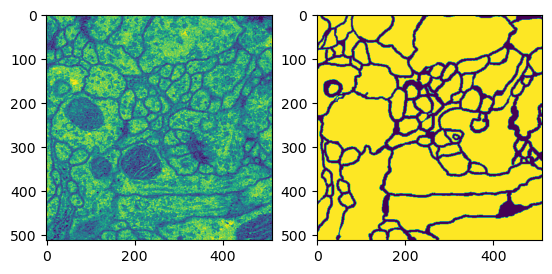

In [7]:
class MyToTensor(object):
    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']

        inputs = inputs.transpose((2, 0, 1)).astype(np.float32)
        labels = labels.transpose((2, 0, 1)).astype(np.float32)

        # 보통은 h,w,c 인데 pytorch는 c, h, w

        data = {'inputs' : torch.from_numpy(inputs), 'labels': torch.from_numpy(labels)}

        return data
    
class MyNormalization(object):
    def __init__(self, mean=0.5,std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']

        inputs = (inputs - self.mean) / self.std

        data = {'inputs' : inputs, 'labels': labels}
        return data
    
class RandomFlip():
    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']

        #50% 좌우 반전
        if np.random.rand() > 0.5:
            inputs = np.fliplr(inputs)
            labels = np.fliplr(labels)

        if np.random.rand() > 0.5:
            inputs = np.flipud(inputs)
            labels = np.flipud(labels)
        data = {'inputs' : inputs, 'labels': labels}
        return data
    

# data loader 
train_data = MyDataset(data_dir=os.path.join(data_dir, 'train'))
data = train_data.__getitem__(0)
inputs = data['inputs']
labels = data['labels']

print('input shape', inputs.shape)
print('labels shape', labels.shape)

plt.subplot(1,2,1)
plt.imshow(inputs)

plt.subplot(1,2,2)
plt.imshow(labels)


# 모델 학습


In [8]:
# 변수 설정 

lr = 0.001
batch_size = 2
n_epoch = 100

# train model 저장 경로 
ckpt_dir = './checkpoint'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [9]:
train_transform = transforms.Compose([MyNormalization(),
                                      RandomFlip(),
                                      MyToTensor()])

test_transform = transforms.Compose([MyNormalization(),
                                     MyToTensor()])

# dataset
train_set = MyDataset(data_dir=os.path.join(data_dir, 'train'), transform=train_transform)
val_set = MyDataset(data_dir=os.path.join(data_dir, 'val'), transform=train_transform)
test_set = MyDataset(data_dir=os.path.join(data_dir, 'test'), transform=test_transform)

# data loader

train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# loss 추이 확인 

num_data_train = len(train_set)
num_data_val = len(val_set)
num_data_test = len(test_set)

num_batch_train = np.ceil(num_data_train/batch_size)
num_batch_val = np.ceil(num_data_val/batch_size)
num_batch_test = np.ceil(num_data_test/batch_size)

#model
model = UNet().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= lr)
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1)
fb_denorm = lambda x, mean, std: (x*std)+mean
fn_class = lambda x : 1.0*(x>0.5)

def save_model(ckpt_dir, model, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'model': model.state_dict(),
                'optim': optim.state_dict()},
                f'./{ckpt_dir}/model_{epoch:02d}.pth')
    

In [25]:
for epoch in range(n_epoch):
    model.train()
    batch_loss = []
    epoch_loss = []

    for batch, data in enumerate(train_dl, 1):
        labels = data['labels'].to(device)
        inputs = data['inputs'].to(device)

        output = model(inputs)

        loss = fn_loss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss 계산
        batch_loss += [loss.item()]
        batch_loss_mean = np.mean(batch_loss)

    epoch_loss += [batch_loss_mean.item()]

    #model val
    with torch.no_grad():
        model.eval()
        loss_arr = []

        for batch, data in enumerate(val_dl, 1):
            labels = data['labels'].to(device)
            inputs = data['inputs'].to(device)

            output = model(inputs)

            loss = fn_loss(output,labels)
            loss_arr += [loss.item()]

    if epoch % 10 ==0:
        print(f'Train Epoch {epoch}/{n_epoch}\tLoss {np.mean(epoch_loss):.4f}')
        print(f'valid Epoch {epoch}/{n_epoch}\tLoss {np.mean(loss_arr):.4f}')
        save_model(ckpt_dir=ckpt_dir, model=model, optim=optimizer, epoch=epoch)

RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 3.81 GiB total capacity; 2.40 GiB already allocated; 19.44 MiB free; 2.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF